In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import scipy.io as sio
from scipy import linalg
from scipy.optimize import minimize

# path to project root
sys.path.append('c:/users/ananasy/pycharmProjects/data_analysis/')

from task_1 import data_handler
from task_1 import utils

In [2]:
dh = data_handler.DataHandler()

x_simple_train, y_simple_train = dh.get_simple_train_dataset()
x_robust_train, y_robust_train = dh.get_robust_train_dataset()

In [6]:
def simple_case(x_train, y_train, k=7, show_plot=True):
    n = x_train.shape[0]
    x_b = utils.get_x_matrix(x_train, k)
    
    alphas = np.array([10**(-i) for i in range(7)])
    
    w = utils.ridge(x_b, y_train, alphas).T
    losses = []
    for j in range(len(alphas)):
        H = np.dot(x_b, np.dot((alphas[j]*np.eye(k)+np.dot(x_b.T, x_b))**(-1), x_b.T))
        sum = 0
        for i in range(n):
            sum += ((y_train[i] - np.dot(x_b[i].T, w[j])) / (1 - H[i][i])) ** 2
        loss = 1 / n * sum
        losses.append(loss)
    
    if show_plot:
        plt.plot(alphas, np.asarray(losses))
        plt.title("loss <-> alpha")
        plt.show()
    idx = np.argmin(losses)
    print("Min loss: {}".format(np.min(losses)))
    print("Optimal alpha: {}".format(alphas[idx]))
    return w[idx], k, np.min(losses), alphas[idx]

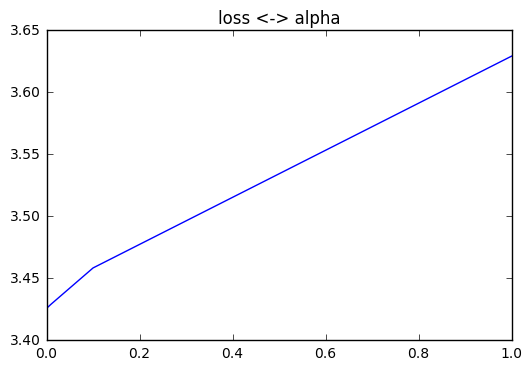

Min loss: 3.4258654989316186
Optimal alpha: 1e-06


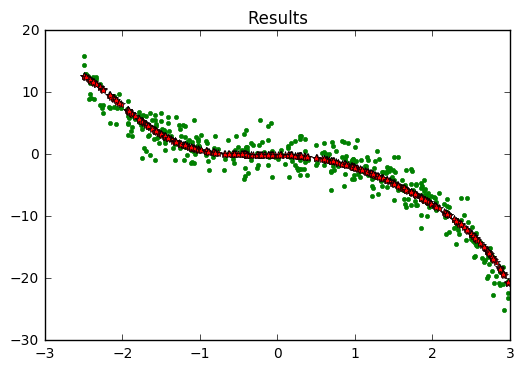

MSE =  4.21969377935


In [13]:
opt_weights, k, _, _ = simple_case(x_simple_train, y_simple_train)

x_simple_test, y_simple_test = dh.get_simple_test_dataset()
x_test_b = utils.get_x_matrix(x_simple_test, k)
prediction = np.dot(x_test_b, opt_weights)

plt.plot(x_simple_test, y_simple_test, 'g.', x_simple_test, prediction, 'r*')
plt.title("Results")
plt.show()

MSE = np.mean((y_simple_test - prediction)**2)
print("MSE = ", MSE)

Min loss: 3.872993124323334
Optimal alpha: 1.0
Min loss: 3.4104704907207783
Optimal alpha: 1e-06
Min loss: 8.55621286522294
Optimal alpha: 1e-06
Min loss: 3.3569242000241077
Optimal alpha: 1e-06
Min loss: 20.53963341700266
Optimal alpha: 1.0
Min loss: 3.4258654989316186
Optimal alpha: 1e-06
Min loss: 2.9220146313234987
Optimal alpha: 1e-06
Min loss: 2.909885254692796
Optimal alpha: 1e-06
Min loss: 2.8941290147683985
Optimal alpha: 1e-06
Min loss: 1.792786403439132
Optimal alpha: 1e-06
Min loss: 1.7203116099530587
Optimal alpha: 1e-06


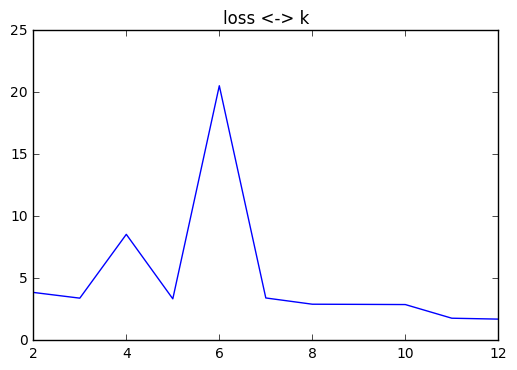

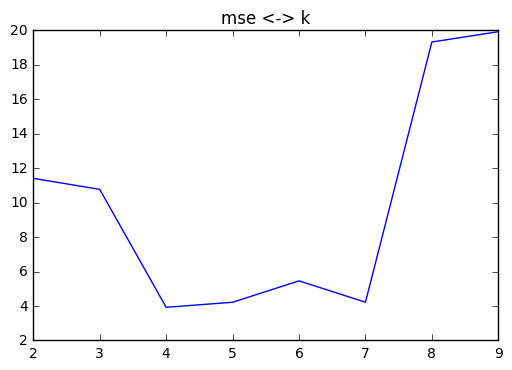

In [19]:
# check different
losses = []
mse = []
k = np.arange(2, 13)
for dim in k:
    opt_weights, _, loss, _ = simple_case(x_simple_train, y_simple_train, dim, False)
    losses.append(loss)
    curr_x_test_b = utils.get_x_matrix(x_simple_test, dim)
    prediction = np.dot(curr_x_test_b, opt_weights)
    
    mse.append(np.mean((y_simple_test - prediction)**2))

mse = np.asarray(mse)
losses = np.asarray(losses)
plt.plot(k, losses)
plt.title("loss <-> k")
plt.show()
plt.plot(k[:8], mse[:8])
plt.title("mse <-> k")
plt.show()

In [4]:
def robust_case(x_train, y_train, k):
    x_b = utils.get_x_matrix(x_train, k)
    optimal_weights = minimize(utils.HuberLoss, x0=np.zeros((k, 1)), args=(x_b, y_train), method='Nelder-Mead')
    
    return optimal_weights.x

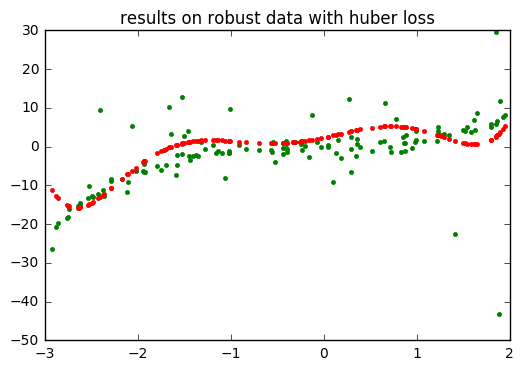

MSE =  48.4870153091


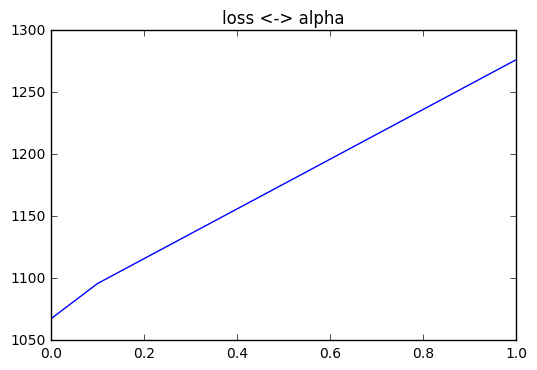

Min loss: 1067.3882253156814
Optimal alpha: 1e-06


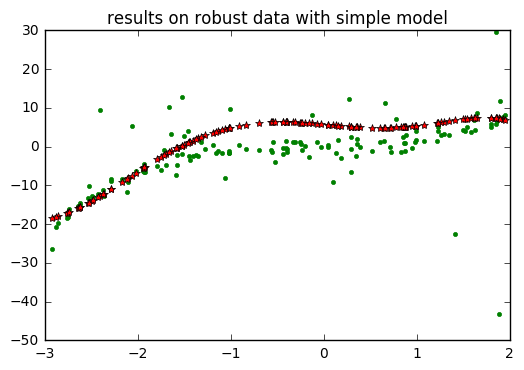

MSE =  57.7511707649


In [7]:
robust_optimal_weights = robust_case(x_robust_train, y_robust_train, 7)

x_robust_test, y_robust_test = dh.get_robust_test_dataset()

x_robust_test_b = utils.get_x_matrix(x_robust_test, 7)

prediction = np.dot(x_robust_test_b, robust_optimal_weights)

plt.plot(x_robust_test, y_robust_test, 'g.', x_robust_test, prediction, 'r.')
plt.title("results on robust data with huber loss")
plt.show()

MSE = np.mean((y_robust_test - prediction)**2)
print("MSE = ", MSE)

robust_simple_opt_weights, _, _, _ = simple_case(x_robust_train, y_robust_train, 7)

prediction = np.dot(x_robust_test_b, robust_simple_opt_weights)

plt.plot(x_robust_test, y_robust_test, 'g.', x_robust_test, prediction, 'r*')
plt.title("results on robust data with simple model")
plt.show()

MSE = np.mean((y_robust_test - prediction)**2)
print("MSE = ", MSE)

In [11]:
def lasso_robust_case(x_train, y_train, k):
    
    x_b = utils.get_x_matrix(x_train, k)
    alphas = np.array([10**(-i) for i in range(7)])
    all_weights = []
    for alpha in alphas:
        w = minimize(utils.lasso, x0=np.ones((k, 1)), args=(alpha, x_b, y_train), method='Nelder-Mead')
        all_weights.append(w.x)
        
    return all_weights

MSE =  49.23948008


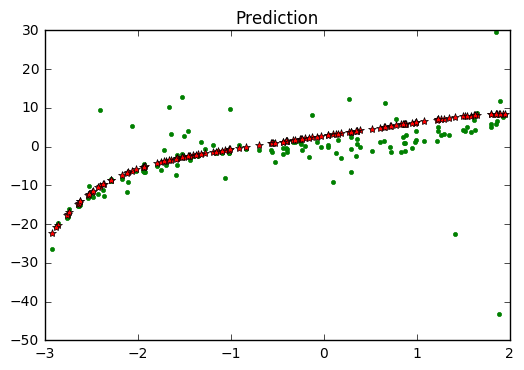

In [13]:
weights = lasso_robust_case(x_robust_train, y_robust_train, 7)

mse_min = sys.float_info.max
opt_weights = np.zeros((7, 1))
best_prediction = np.zeros(())

for i in range(len(weights)):
    curr_prediction = np.dot(x_robust_test_b, weights[i])
    curr_mse = np.mean((y_robust_test - curr_prediction)**2)
    if curr_mse < mse_min:
        mse_min = curr_mse
        opt_weights = weights[i]
        best_prediction = curr_prediction

print("MSE = ", mse_min)
plt.plot(x_robust_test, y_robust_test, 'g.', x_robust_test, best_prediction, 'r*')
plt.title("Prediction")
plt.show()